In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from scipy import linalg

In [2]:
train_data = np.genfromtxt('X_train.csv', delimiter=',')
train_label = np.genfromtxt('T_train.csv', delimiter=',')
test_data = np.genfromtxt('X_test.csv', delimiter=',')
test_label = np.genfromtxt('T_test.csv', delimiter=',')

In [3]:
train_data.shape, train_label.shape

((5000, 784), (5000,))

In [13]:
# some common function
def showEigen(eigen_values, eigen_vectors, isMin=True, show_number=6):
    # show eigen vector with min/max eigen value
    sort_idxs = np.argsort(np.abs(eigen_values))
    if not isMin:
        sort_idxs = np.flip(sort_idxs)

    plt.plot(np.abs(eigen_values[sort_idxs[:show_number]]),'.')
    plt.xticks(range(show_number), sort_idxs[:show_number])
    plt.title('Eigen values')
    plt.xlabel('index of eigen vector')
    plt.show()

    plt.figure(figsize=(4*show_number,3))

    for i in range(show_number):
        plt.subplot(1, show_number, i+1)
        plt.plot(np.abs(eigen_vectors[:,sort_idxs[i]]))
        plt.title('Eigen vectors '+str(sort_idxs[i]))

    plt.show()
    
def showCluster(datas, labels):
    for t in np.unique(labels):
        mask = labels == t
        plt.plot(datas[mask,0], datas[mask,1], '.', label='label '+str(t))
    
    plt.legend()

# PCA Principal Components Analysis

find a orthogonal projection $W$ has minimum MSE(mean square error)

$$ z = xW \\
MSE = ||x - zW^T||^2 = || x - xWW^T ||^2 \\
= \text{constant} - \text{constant}W^TSW, S_{i,j} = \frac{\sum_{k=1}^N (x_{k}(i) - \bar{x(i)})(x_{k}(j) - \bar{x(j)})^T}{N}, x = \left[ \begin{matrix} x(0) \\ x(1) \\ \vdots \\ x(d) \end{matrix} \right]$$

$W^TSW$ is covariance matrix, so we can maximize $W^TSW$ and get minimum MSE

It become a Rayleigh quotient problem, find eigen vector with max eigen value.

### kernel PCA

$$ \frac{(\phi(X) - \frac{ \sum_{i}^n \phi(Xi)}{N} )(\phi(X) - \frac{ \sum_{i}^n \phi(Xi)}{N})^T}{N} W = \lambda W , W = \phi(X)\alpha \\
\Rightarrow (K - 1_N K - K 1_N + 1_N K 1_N)\alpha = \lambda N\alpha
\\ z = \phi(x)W = \phi(x)\phi(X)\alpha = K(x,X)\alpha $$

In [146]:
def covariance(x, y):
    x1 = x - np.sum(x, axis = 1)[:,None]
    y1 = y - np.sum(y, axis = 1)[:,None]
    return np.matmul(x1, y1.T)/ x1.shape[1]

def PCA(datas, k, kernel=None):
    if callable(kernel):
        datas = kernel(datas, datas)
        N = datas.shape[0]
        N1 = np.ones((N,N))/N
        S = (datas 
             - np.matmul(N1, datas) 
             - np.matmul(datas, N1) 
             + np.matmul(np.matmul(N1, datas), N1)
            )/N
    else:
        S = covariance(datas.T, datas.T)
    
    value, vector = np.linalg.eig(S)
    
    max_idxs = np.flip(np.argsort(np.abs(value)))
    W = np.concatenate([
        np.abs(vector[:, max_idxs[i]])[:,None] 
        for i in range(k)
    ], axis=1)
    
    return np.matmul(datas, W), W    

In [97]:
# parameter
dim = 2
S = covariance(train_data.T, train_data.T)
S.shape

(784, 784)

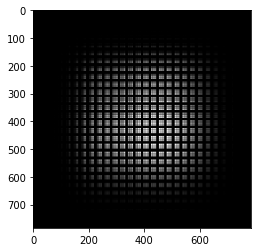

In [98]:
plt.imshow(S, cmap='gray')

In [99]:
%%time
eigen_values, eigen_vectors = linalg.eig(S)

CPU times: user 5.56 s, sys: 9.36 s, total: 14.9 s
Wall time: 2.32 s


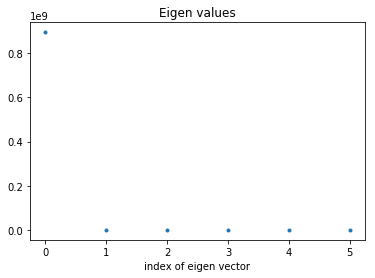

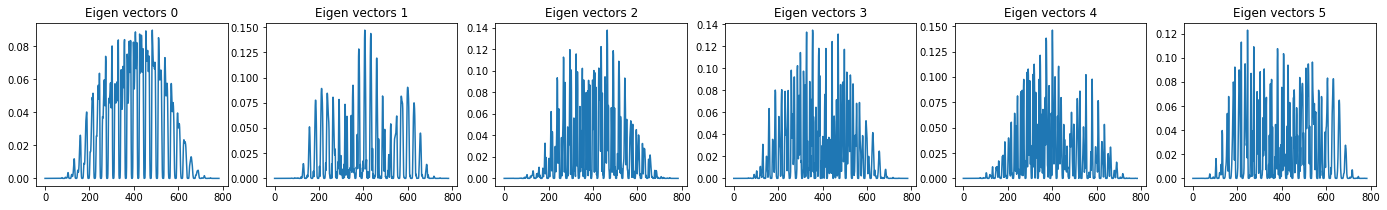

In [100]:
# show eigen vector with max eigen value
showEigen(eigen_values, eigen_vectors, isMin=False)

In [129]:
max_idxs = np.flip(np.argsort(np.abs(eigen_values)))
W = np.concatenate([np.abs(eigen_vectors[:, max_idxs[i]])[:,None] for i in range(dim)], axis=1)
W.shape    

(784, 2)

In [130]:
PCA_space = np.matmul(train_data, W)
PCA_space.shape

(5000, 2)

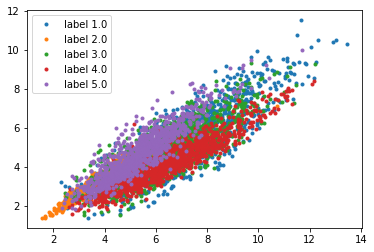

In [131]:
showCluster(PCA_space, train_label)

In [147]:
kPCA_space, kPCA_w = PCA(train_data, 2, kernel=LinearKernel())

In [150]:
kPCA_space2, kPCA_w2 = PCA(train_data, 2, kernel=RBFKernel(1/100))

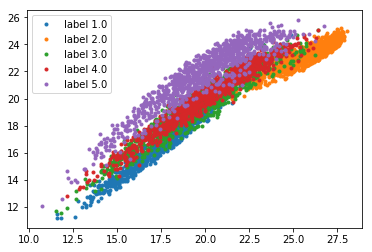

In [151]:
showCluster(kPCA_space2, train_label)

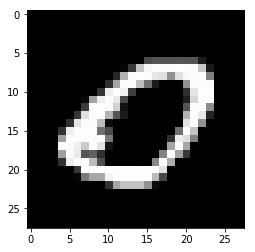

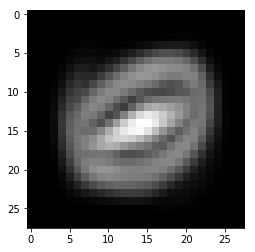

In [132]:
i = 0
plt.imshow(train_data[i].reshape(28,28), cmap='gray')
plt.show()
plt.imshow(np.matmul(np.matmul(train_data[i],W), W.T).reshape(28,28), cmap='gray')

# LDA Linear Discriminative Analysis

- has $k$ classes
- maximize between-class-scatter $S_B = \sum_{j=1}^k |C_j|(m_j - m)(m_j - m)^T, m = \frac{\sum x}{n}, m_j = \frac{\sum_{x_i \in C_j} x_i}{|C_j|}$
- minimize within-class-scatter  $S_W = \sum_{j=1}^k \sum_{x_i \in C_j} (x_i - m_j)(x_i - m_j)^T$
- solve eigen problem $ S_B W = \lambda S_W W  \Rightarrow S_W^{-1} S_B W = \lambda W$

## kernel LDA


In [138]:
def LDA(datas, labels, k, kernel=None):
    C = np.zeros((datas.shape[0], len(np.unique(labels))))
    for idx, j in enumerate(np.unique(labels)):
        C[labels == j,idx] = 1;
    
    Mj = np.matmul(datas.T, C) / np.sum(C, axis = 0)
    M = np.sum(datas.T, axis = 1) / datas.shape[0]
    
    B = Mj - M[:,None]    
    SB = np.matmul(B * np.sum(C, axis = 0), B.T) 
    
    W = datas.T - np.matmul(Mj, C.T)
    SW = np.matmul(W, W.T)
    
    try:
        SW_inv = np.linalg.inv(SW)
    except:
        SW_inv = np.linalg.pinv(SW)
    
    SBW = np.matmul(SW_inv, SB)
    value, vector = np.linalg.eig(SBW)
    
    max_idxs = np.flip(np.argsort(np.abs(value)))
    W = np.concatenate([
        np.abs(vector[:, max_idxs[i]])[:,None] 
        for i in range(k)
    ], axis=1)
    
    return np.matmul(datas, W), W 

In [16]:
# parameter
dim = 2
C = np.zeros((train_data.shape[0], len(np.unique(train_label))))
for idx, j in enumerate(np.unique(train_label)):
    C[train_label == j,idx] = 1;

Mj = np.matmul(train_data.T, C) / np.sum(C, axis = 0)
M = np.sum(train_data.T, axis = 1) / train_data.shape[0]
B = Mj - M[:,None]    
SB = np.matmul(B * np.sum(C, axis = 0), B.T) 
W = train_data.T - np.matmul(Mj, C.T)
SW = np.matmul(W, W.T)

SB.shape, SW.shape

((784, 784), (784, 784))

In [17]:
SBW = np.matmul(np.linalg.pinv(SW), SB)
SBW.shape

(784, 784)

In [92]:
%%time
eigen_values, eigen_vectors = linalg.eig(SBW)

CPU times: user 6.39 s, sys: 10.8 s, total: 17.2 s
Wall time: 2.46 s


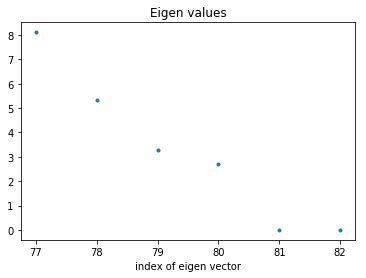

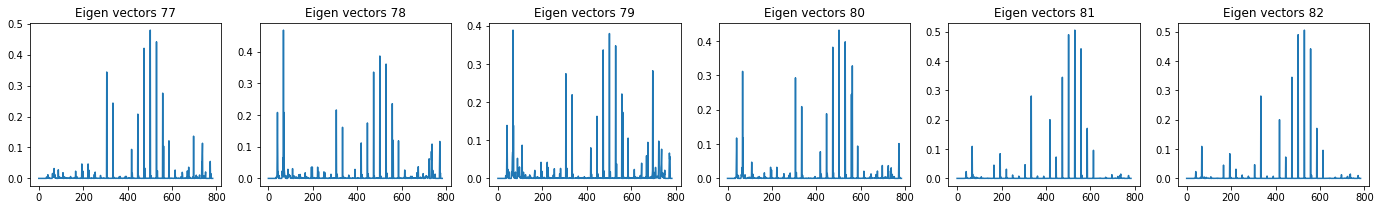

In [93]:
# show eigen vector with max eigen value
showEigen(eigen_values, eigen_vectors, isMin=False)

In [94]:
max_idxs = np.flip(np.argsort(np.abs(eigen_values)))
W = np.concatenate([np.abs(eigen_vectors[:, max_idxs[i]])[:,None] for i in range(dim)], axis=1)
W.shape 

(784, 2)

In [95]:
LDA_space = np.matmul(train_data, W)
LDA_space.shape

(5000, 2)

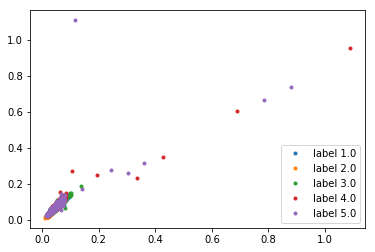

In [96]:
showCluster(LDA_space, train_label)

# RatioCut and NormalizedCut

- SimpleCut
    - $ \Rightarrow L = D - W $
- RatioCut
    - $ \Rightarrow L_R = \frac{D-W}{|V|}$
- NormalizedCut
    - $ \Rightarrow L_N = D^{-\frac{1}{2}}LD^{-\frac{1}{2}} $
- GeneralizeCut
    - $ \Rightarrow L_G = D^{-1}L $

In [23]:
def Linear(u,v):
    return np.matmul(u, v.T);
    
def Euclidean(x,y):
    """
    calculate Euclidean distance
    parameters:
        x: n1 * d, y: n2 x d
    return:
        d: n1 * n2
        
    d(i, j) = |x(i) - y(j)|^2
    """
    if len(x.shape)==1:
        x = x[None,:]
    if len(y.shape)==1:
        y = y[None,:]
    return np.matmul(x**2, np.ones((x.shape[1],y.shape[0]))) \
    + np.matmul(np.ones((x.shape[0],x.shape[1])), (y**2).T) \
    - 2*np.dot(x,y.T)

def RBF(u,v,gamma=1):
    return np.exp(-1*gamma*Euclidean(u,v));

def LinearKernel():
    return lambda u,v:Linear(u,v)
    
def RBFKernel(gamma=1):
    """
    generate callable function for RBF kernel
    parameters:
        gamma : default is 1
    return:
        lambda(u, v)
        
    rbf(u, v) = exp(-gamma|u-v|^2)
    """
    return lambda u,v:RBF(u,v,gamma)

def LinearRBFKernel(gamma=1):
    return lambda u,v:Linear(u,v) + RBF(u,v,gamma)

In [24]:
def KernelTrick(gram_m, c):
    """
    calculate Euclidean distance in feature space by kernel trick
    parameters:
        gram_m : gram matrix K(x, x)
        c : cluster vector c(i,k) = 1 if x(i) belong k clustering
    return:
        w : n*k
    """
    return (
        np.matmul(
        gram_m * np.eye(gram_m.shape[0]), 
        np.ones((gram_m.shape[0], c.shape[1])) 
    ) \
    - 2*( np.matmul(gram_m, c) / np.sum(c, axis=0) ) \
    + (np.matmul(
        np.ones((gram_m.shape[0], c.shape[1])), 
        np.matmul(np.matmul(c.T, gram_m), c)*np.eye(c.shape[1])
    ) / (np.sum(c,axis=0)**2) )
    )

def RandomCluster(n,k):
    """
    get random cluster c
    """
    c = np.zeros((n,k))
    c[np.arange(n),np.random.randint(k,size=n)] = 1             
    return c

def RandomMean(k,dim):
    """
    get random mean
    """
    return -1 + 2*np.random.random((k,dim))

def GetMeanFromCluster(datas, c):
    """
    get mean from cluster c
    """
    if np.count_nonzero(np.sum(c, axis=0) == 0):
        raise ArithmeticError
    return np.matmul(c.T, datas) / np.sum(c, axis=0)[:,None]

def GetCluster(w):
    """
    get cluster from w (distance between x and u)
    """
    new_c = np.zeros(w.shape)
    new_c[np.arange(w.shape[0]),np.argmin(w, axis=1)] = 1
    return new_c

def kmeans(datas, k, 
           initial_u=None, 
           initial_c=None,
           isKernel=False, 
           converge_count = 1
          ):
    """
    use generator to iter steps
    parameters:
        datas : data points
        k : how many cluster
        initial_u : assign mean u
        initial_c : assign cluster c
        isKernel : use kernel k-means (default is False)
    return:
        python generator
        
    next() will get cluster c and mean u
    e.g.
        c, u = next(g)
    if converge, next() will raise Error
    """
    
    # initialization
    if isKernel:
        gram_matrix = datas
        c = initial_c if type(initial_c)!=type(None) \
            else RandomCluster(datas.shape[0], k)
    else:
        u = initial_u if type(initial_u)!=type(None) \
            else RandomMean(k,datas.shape[1])
        c = np.zeros((datas.shape[0],k))
    
    while(1):
        # E-step
        if not isKernel:
            w = Euclidean(datas, u)
        else:
            w = KernelTrick(gram_matrix, c)

        # M-step
        update_c = np.zeros(w.shape)
        update_c[np.arange(w.shape[0]),np.argmin(w, axis=1)] = 1
    
        delta_c = np.count_nonzero(np.abs(update_c - c))
        if not isKernel:
            u = GetMeanFromCluster(datas, update_c)
        else:
            u = None
        
        yield update_c, u
        
        if delta_c == 0:
            converge_count-=1
            # find converge
            if converge_count == 0:
                break
        
        c = update_c
    
    return

In [25]:
def __normalizecut(W,D):
    d = np.sqrt(np.linalg.inv(D))
    return np.matmul(np.matmul(d, D-W), d)

def __generalizecut(W,D):
    return np.matmul(np.linalg.inv(D), D-W)

__spectral_cut = {
    0 : lambda W,D:D-W,
    1 : lambda W,D:(D-W)/D.shape[0],
    2 : __normalizecut,
    3 : __generalizecut,
}
def Spectral(datas, kernel, k, cutType=0):
    """
    spectral clustering
    parameters:
        datas : data source n*d
        kernel : function for compute kernel
        k : mapping data to k-dim eigen space
        cutType:
            - 0 : simple cut, D-W
            - 1 : ratio cut, (D-W)/|V|
            - 2 : normalize cut, D^-1/2(D-W)D^-1/2
            - 3 : generalize cut, D^-1(D-W)
    return:
        U : data in eigen space n*k
        eigen values : n*1
        eigen vector : n*n
    """
    if not callable(kernel):
        raise AttributeError;
    W = kernel(datas, datas)
    D = np.sum(W, axis=1)*np.eye(W.shape[0])
    
    if not cutType in __spectral_cut:
        raise AttributeError;
    L = __spectral_cut[cutType](W,D)    
    
    eig_values, eig_vectors = np.linalg.eig(L)
    # minimize cut
    min_idxs = np.argsort(eig_values)
    
    U = np.concatenate([eig_vectors[:,min_idxs[i]][:,None] for i in range(k)], axis=1)
    
    if __spectral_cut[cutType] == __normalizecut:
        U = U / np.sqrt(np.sum(U**2, axis=1))[:,None]
    
    return U, eig_values, eig_vectors

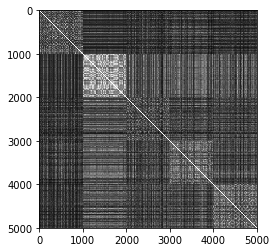

In [58]:
plt.imshow(RBFKernel(1/100)(train_data, train_data), cmap='gray')

In [71]:
%%time
eigen_space, eigen_values, eigen_vectors = Spectral(train_data, LinearRBFKernel(1/300), 2, cutType=2)

CPU times: user 16min 53s, sys: 4min 5s, total: 20min 59s
Wall time: 3min 3s


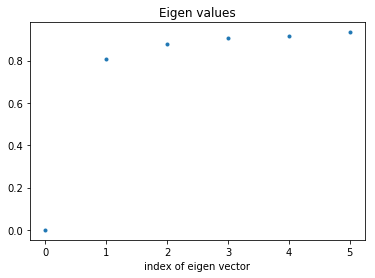

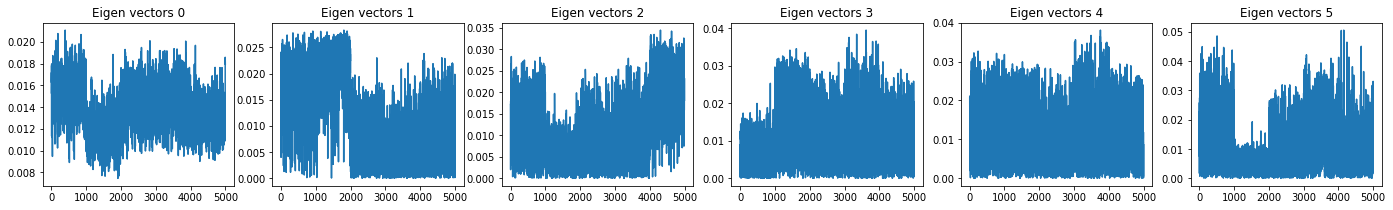

In [77]:
showEigen(eigen_values, eigen_vectors, show_number=6)

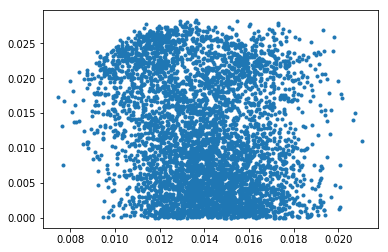

In [73]:
plt.plot(np.abs(eigen_space[:,0]),np.abs(eigen_space[:,1]),'.')

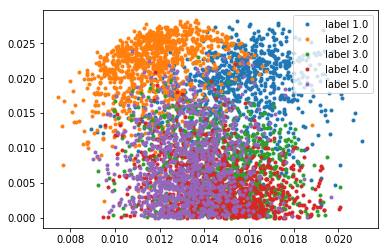

In [74]:
showCluster(np.abs(eigen_space), train_label)

In [82]:
min_idxs = np.argsort(eigen_values)
    
U5 = np.concatenate([eigen_vectors[:,min_idxs[i]][:,None] for i in range(5)], axis=1)
#showCluster(np.abs(U), train_label)

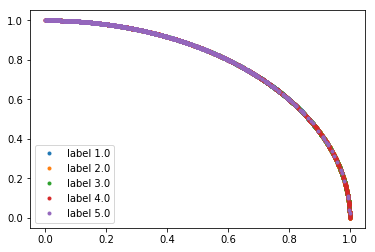

In [79]:
U2 = U / np.sqrt(np.sum(U**2, axis=1))[:,None]
showCluster(np.abs(U2), train_label)

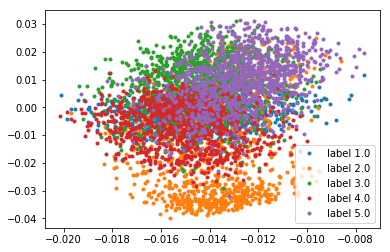

In [85]:
tmp, _ = PCA(U5, 2)
showCluster(tmp, train_label)

# eigen faces

In [201]:
import PIL.Image
att_faces_data = []
for i in range(1,41):
    for j in range(1,11):
        with PIL.Image.open('./att_faces/s{}/{}.pgm'.format(i, j)) as im:
            att_faces_data += [np.array(im).reshape(1,-1)]
            
att_faces_data = np.concatenate(att_faces_data, axis = 0)
att_faces_data.shape

(400, 10304)

In [164]:
from IPython import display

In [207]:
all_faces = []
for i in range(40):
    all_faces += [np.concatenate(att_faces_data[10*i:10*(i+1)].reshape(10,112,92), axis=1)]
    
all_faces = np.concatenate(all_faces, axis=0)
all_faces.shape

(4480, 920)

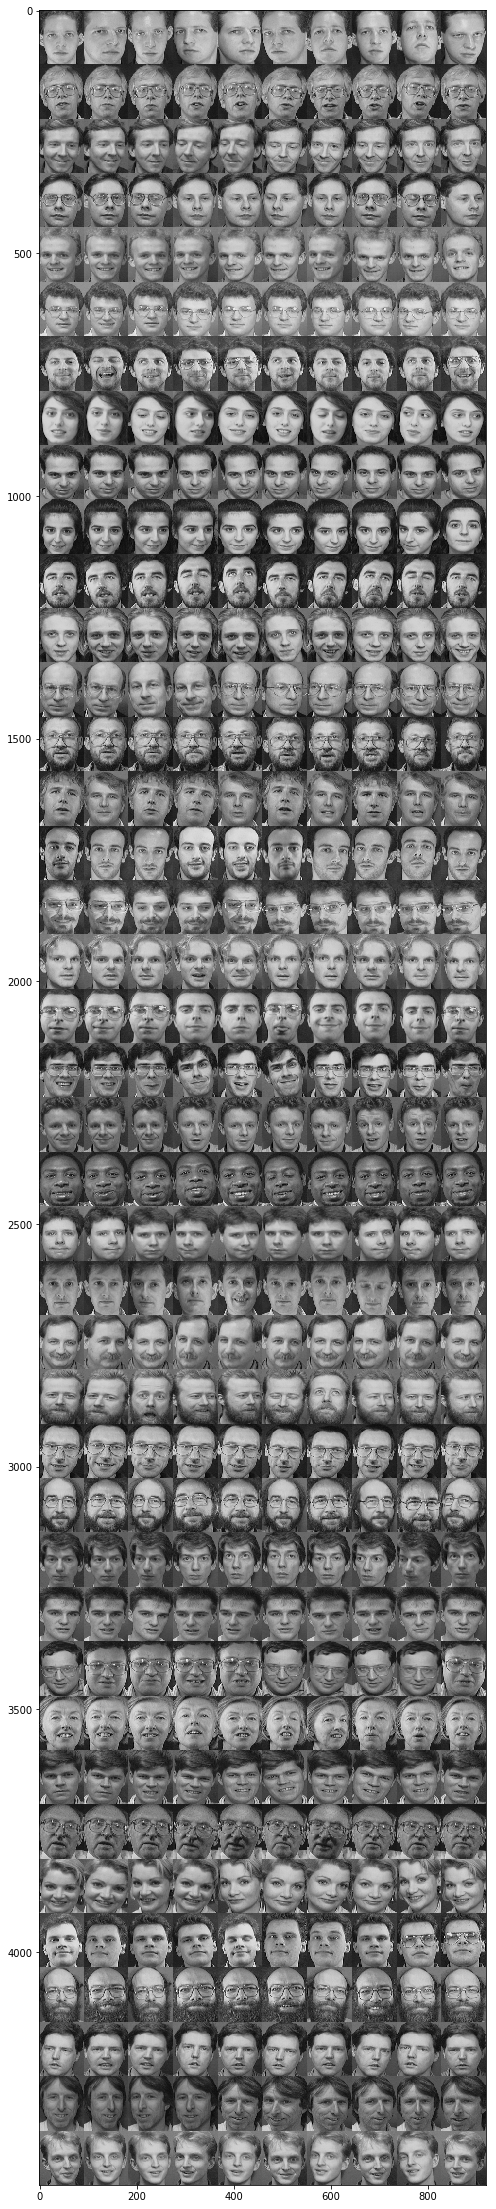

In [208]:
plt.figure(figsize=(80,40))
plt.imshow(all_faces, cmap='gray')